In [16]:
import numpy as np
import scipy as sc
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [17]:
headers = []
datas = []
for run in glob('../data/position_grill/*'):
    header = np.loadtxt(run, delimiter='\t', skiprows=1, max_rows=1, unpack=True)
    p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
    headers.append(header)

    data = np.loadtxt(run, delimiter='\t', skiprows=2, unpack=True)
    V_in, V_out, *_ = data
    I_out = V_out / (10 * G)

    values, counts = np.unique_counts(V_in)
    V_in_combined = np.zeros_like(values)
    I_out_combined = np.zeros_like(values)
    I_out_std_combined = np.zeros_like(values)
    for i, (value, count) in enumerate(zip(values, counts)):
        idx = np.nonzero(V_in == value)
        V_in_combined[i] = value
        I_out_combined[i] = np.mean(I_out[idx])
        I_out_std_combined[i] = np.std(I_out[idx])

    datas.append((V_in_combined, I_out_combined, I_out_std_combined))

## Find V_{sp}, ln(I_{es})

In [18]:
def set_all_between(arr):
    idx = np.nonzero(arr)[0]
    idx_start, idx_stop = idx[0], idx[-1]
    arr[idx_start:idx_stop+1] = True
    return arr

In [19]:
p = plt.rcParams
p["scatter.marker"] = '.'
p["lines.markersize"] = 1
p["errorbar.capsize"] = 2

p["figure.figsize"] = (6.5*CM_PER_INCH, 6.5*CM_PER_INCH)
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.22
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.85
p['figure.subplot.bottom'] = 0.28

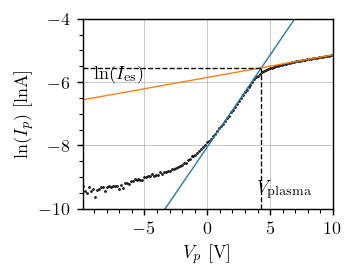

In [20]:
T_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
T = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))
n_e = unp.uarray(np.zeros(len(datas)), np.zeros(len(datas)))

B_fit_start = np.ones(len(datas))*1.5
B_fit_stop = np.ones(len(datas))*3
C_fit_start = np.ones(len(datas))*6


for i, (header, data) in enumerate(zip(headers, datas)):
    if (i == 11) :
        p, d, G, A, f, I_chauffage, V_polarisation, *V_grill = header
        V_in, I_out, I_out_std = data

        # print(f"Fit number {i}")

        dydx = np.gradient(np.nan_to_num(np.log(I_out), nan=1), V_in)
        threshold = 7e-2
        idx = np.abs(np.diff(dydx, prepend=0)) < threshold
        idx = np.logical_and(idx, V_in > B_fit_start[i])
        idx_B = set_all_between(np.logical_and(idx, V_in < B_fit_stop[i]))
        idx_C = set_all_between(np.logical_and(idx, V_in > C_fit_start[i]))
        # idx_B = np.logical_and(0 < V_in, V_in < 3)
        # idx_C = V_in > 6

        coefsB, covB = np.polyfit(V_in[idx_B], np.log(I_out[idx_B]), 1, cov=True)
        coefs_errB = unp.uarray(coefsB, np.sqrt(np.diag(covB)))
        fitfuncB = np.poly1d(coefsB)
        coefsC, covC = np.polyfit(V_in[idx_C], np.log(I_out[idx_C]), 1, cov=True)
        coefs_errC = unp.uarray(coefsC, np.sqrt(np.diag(covC)))
        fitfuncC = np.poly1d(coefsC)

        # Plot
        plt.ylim(-10, -4)
        plt.autoscale(axis='x', tight=True)

        x = np.linspace(V_in[0], V_in[-1])
        plt.scatter(V_in, np.log(I_out), c='k', label=f"$I_c = {header[5]}")
        plt.plot(x, fitfuncB(x),
                 lw=0.75)
        plt.plot(x, fitfuncC(x),
                 lw=0.75)

        V_sp = -(coefs_errC[1] - coefs_errB[1]) / (coefs_errC[0] - coefs_errB[0])
        I_sp = umath.exp(coefs_errB[0] * V_sp + coefs_errB[1])
        # print(V_sp, I_sp)
        plt.vlines(x=V_sp.n, ymin=plt.ylim()[0],ymax=umath.log(I_sp).n, 
                   linestyles='--', colors='k', lw=0.75)
        plt.hlines(y=umath.log(I_sp).n, xmin=plt.xlim()[0], xmax=V_sp.n,
                   linestyles='--', colors='k', lw=0.75)
        plt.text(4,-9.5, r"$V_{\mathrm{plasma}}$")
        plt.text(-9, -5.9, r"$\ln (I_{\mathrm{es}})$")


        T_e_run = 1/coefs_errB[0] * ELEMENTARY_CHARGE / BOLTZMANN_CONSTANT_JOULE
        T_e_run += ufloat(0, 0.05e4)
        T_run = T_e_run * BOLTZMANN_CONSTANT_ELECTRONVOLT
        # TODO: verifier unitées
        n_e_run = 4 / (ELEMENTARY_CHARGE * SURFACE_PROBE) * unp.sqrt(2 * np.pi * ELECTRON_MASS / (BOLTZMANN_CONSTANT_JOULE * T_e_run)) * I_sp
        # print(f"{T_e_run = :.1ueP}, {T_run = :.1ueP}, {n_e_run = :.1ueP}")
        T_e[i] = T_e_run
        T[i] = T_run
        n_e[i] = n_e_run

        plt.xlabel("$V_p$ [V]")
        plt.ylabel(r"$\ln (I_p)$ [$\ln$A]")

        plt.savefig("../figures/IV_fit.pdf")
        plt.show()

    # plt.legend()